## Importing Neccessary Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

## Load Dataset

In [2]:
# Load dataset from Data folder
df = pd.read_excel("data/flight_fares.xlsx")

# To stretch head function output to the notebook width
pd.set_option('display.max_columns', None)

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.info()       # To get the information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10001 non-null  object
 1   Date_of_Journey  10001 non-null  object
 2   Source           10001 non-null  object
 3   Destination      10001 non-null  object
 4   Route            10000 non-null  object
 5   Dep_Time         10001 non-null  object
 6   Arrival_Time     10001 non-null  object
 7   Duration         10001 non-null  object
 8   Total_Stops      10000 non-null  object
 9   Additional_Info  10001 non-null  object
 10  Price            10001 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 859.6+ KB


### Check for missing values

In [4]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
df.dropna(inplace = True)

In [6]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## Feature Engineering

### Handling Object Data
**`Date_of_Journey`, `Dep_Time`, `Arrival_Time`, `Duration` are object datatype.** To derive numeric features on these, we use pandas `to_datetime` method to convert object data type to datetime datatype.

<span style="color: red;">Attribute `.dt.day`  will extract day from the date</span>\
<span style="color: red;">Attribute `.dt.month` will extract  month from that date</span>

In [7]:
# Date_of_Journey is the day when plane departs. 
df["journey_day"] = pd.to_datetime(df.Date_of_Journey, format="%d/%m/%Y").dt.day
df["journey_month"] = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y").dt.month
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [8]:
# Since we converted Date_of_Journey column into integers, Now we can drop as it is of no use.
df.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [9]:
# Departure time is the time when a plane leaves the source airport.
# Similar to Date_of_Journey we can extract values from Dep_Time
# Extracting Hours
df["dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
# Extracting Minutes
df["dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute
# Now we drop Dep_Time as it is of no use
df.drop(["Dep_Time"], axis = 1, inplace = True)

In [10]:
# Arrival time is the time when the plane reaches the destination airport.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
df["arrival_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
# Extracting Minutes
df["arrival_min"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
# Now we can drop Arrival_Time as it is of no use
df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [11]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [12]:
# Duration is the time taken by plane to reach destination
# It is the difference betwen Arrival Time and Departure time
# Assigning and converting Duration column into list, for looping through
duration = list(df["Duration"])
# In table above, Row Index=2, we have Duration = 19h (missing minutes)
# Looping through all duration values, to ensure it has both hours & mins: 'xh ym'
for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour
# Prepare separate duration_hours and duration_mins lists
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Add duration_hours and duration_mins list to our dataset df
df["Duration_hours"] = duration_hours
df["Duration_mins"] = duration_mins
# Drop Duration column from the dataset
df.drop(["Duration"], axis = 1, inplace = True)

df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


### Handling Categorical Data

In [13]:
# Feature engineering on: Airline
df["Airline"].value_counts()

Jet Airways                          3598
IndiGo                               1927
Air India                            1633
Multiple carriers                    1129
SpiceJet                              769
Vistara                               447
Air Asia                              296
GoAir                                 179
Multiple carriers Premium economy      13
Jet Airways Business                    5
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [14]:
# Grouping airlines with less than 100 flights as 'Others'
infrequent_airlines = ~df['Airline'].isin(['Jet Airways', 'IndiGo', 'Air India', 'SpiceJet', 'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia'])

df.loc[infrequent_airlines, 'Airline'] = 'Others'

df['Airline'].value_counts()

Jet Airways          3598
IndiGo               1927
Air India            1633
Multiple carriers    1129
SpiceJet              769
Vistara               447
Air Asia              296
GoAir                 179
Others                 22
Name: Airline, dtype: int64

In [15]:
Airline = pd.get_dummies(df['Airline'],prefix='Airline', drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Others,Airline_SpiceJet,Airline_Vistara
0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [16]:
# Feature engineering on: Source
df["Source"].value_counts()

Delhi       4257
Kolkata     2678
Banglore    2058
Mumbai       647
Chennai      360
Name: Source, dtype: int64

In [17]:
# As Source is Nominal Categorical data we will perform OneHotEncoding
Source = pd.get_dummies(df['Source'],prefix='Source',drop_first= True) 
# drop_first= True means we drop the first column to prevent multicollinearity
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [18]:
# Feature engineering on Destination
df["Destination"].value_counts()

Cochin       4257
Banglore     2678
Delhi        1191
New Delhi     867
Hyderabad     647
Kolkata       360
Name: Destination, dtype: int64

In [19]:
# Renaming destination 'New Delhi' to 'Delhi' to match with Source
df['Destination'] = df['Destination'].replace('New Delhi', 'Delhi')

# As Destination is Nominal Categorical data we will perform OneHotEncoding
Destination = pd.get_dummies(df['Destination'],prefix='Destination',drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [20]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
df.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [21]:
# Feature engineering on: Total_Stops
df["Total_Stops"].value_counts()

1 stop      5281
non-stop    3259
2 stops     1415
3 stops       44
4 stops        1
Name: Total_Stops, dtype: int64

In [22]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys
df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
df.head()

,Airline,Source,Destination,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


In [23]:
# Concatenate dataframe --> train_data + Airline + Source + Destination
df_1 = pd.concat([df, Airline, Source, Destination], axis = 1) # axis = 1 signifies column
df_1.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

df_1.head()

,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Others,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [24]:
df_1.shape

(10000, 26)

In [25]:
X = df_1.drop(['Price'], axis = 1)
y = df_1['Price']


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [27]:
def evaluate_models(X, y):
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define models and parameter grids
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
        'ExtraTrees': ExtraTreesRegressor(random_state=42)
    }

    param_grids = {
        'RandomForest': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20],
            'max_features': [1.0, 'sqrt', 'log2'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'GradientBoosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.05],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.05],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'ExtraTrees': {
            'n_estimators': [100, 200, 300],
            'max_features': [1.0, 'sqrt', 'log2'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [None, 10, 20, 30]
        }
    }

    best_models = {}
    results = []

    for model_name in models:
        model = models[model_name]
        param_grid = param_grids[model_name]
        randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, verbose=0, n_jobs=-1, random_state=42, scoring='r2')
        randomized_search.fit(X_train, y_train)
        best_models[model_name] = randomized_search.best_estimator_
        print(f"Best parameters for {model_name}: {randomized_search.best_params_}")

        # Evaluate the best model
        best_model = randomized_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # Append results
        results.append({
            'Model': model_name,
            'R² Score': r2,
            'MSE': mse,
            'RMSE': rmse
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [28]:
models_report = evaluate_models(X,y)

Best parameters for RandomForest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 20}
Best parameters for GradientBoosting: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
Best parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best parameters for ExtraTrees: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 30}


In [29]:
models_report

,Model,R² Score,MSE,RMSE
0,RandomForest,0.858497,2.811089e+06,1676.630384
1,GradientBoosting,0.874443,2.494306e+06,1579.337233
2,XGBoost,0.873078,2.521436e+06,1587.903111
3,ExtraTrees,0.873806,2.506970e+06,1583.341271


In [30]:
final_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.9, random_state=42)
final_model.fit(X, y)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=2, random_state=42,
                          subsample=0.9)

### Model Performance

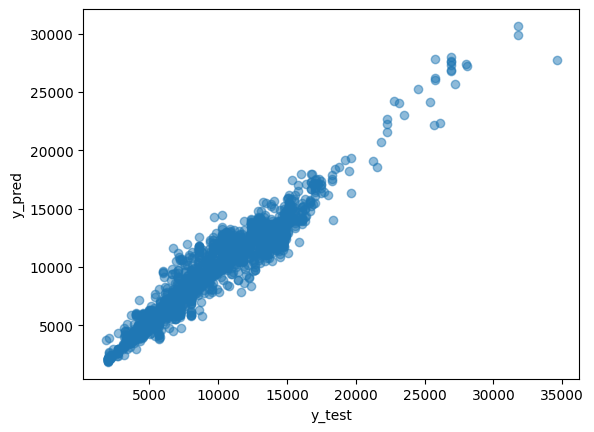

In [33]:
# Plot performance graph
y_pred = final_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### Save the model .pkl

In [34]:
import pickle
# open a file, where you ant to store the data
with open('reg_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [36]:
df_1

,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Others,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2,15965,27,6,15,5,1,30,10,25,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
9997,1,10844,6,5,6,30,18,15,11,45,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
9998,0,6121,12,5,13,20,16,10,2,50,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9999,0,3625,24,4,22,10,1,0,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [37]:
feature_importance = pd.DataFrame(final_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importance

,importance
Duration_hours,0.451446
journey_day,0.141361
Airline_Jet Airways,0.067782
journey_month,0.063076
Airline_Others,0.046268
Total_Stops,0.035315
arrival_hour,0.033068
dep_hour,0.024813
Airline_Multiple carriers,0.020158
Destination_Delhi,0.019520


# Prediction on Unseen data

In [7]:
import pandas as pd

bf = pd.read_csv('business.csv')
bf.head(15)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"
5,11-02-2022,Vistara,UK,985,19:50,Delhi,02h 10m,non-stop,22:00,Mumbai,"50,264"
6,11-02-2022,Air India,AI,479,21:15,Delhi,17h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,15:00,Mumbai,"50,669"
7,11-02-2022,Air India,AI,473,18:40,Delhi,22h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:25,Mumbai,"51,059"
8,11-02-2022,Vistara,UK,871,20:35,Delhi,17h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:30,Mumbai,"51,731"
9,11-02-2022,Vistara,UK,977,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"53,288"


In [8]:
ef = pd.read_csv('economy.csv')
ef.head(15) 

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"
5,11-02-2022,Vistara,UK,945,11:40,Delhi,02h 20m,non-stop,14:00,Mumbai,"5,955"
6,11-02-2022,Vistara,UK,927,09:30,Delhi,02h 05m,non-stop,11:35,Mumbai,"6,060"
7,11-02-2022,Vistara,UK,951,14:20,Delhi,02h 10m,non-stop,16:30,Mumbai,"6,060"
8,11-02-2022,GO FIRST,G8,334,08:00,Delhi,02h 10m,non-stop,10:10,Mumbai,"5,954"
9,11-02-2022,GO FIRST,G8,336,14:20,Delhi,02h 15m,non-stop,16:35,Mumbai,"5,954"


In [6]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [10]:
bf.shape[0]+ef.shape[0]

300261